# Setup

In [55]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/device:CPU:0']


[]

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import h5py
import os
import pickle

In [42]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

# Model Performance

Our network receives a video of blinking emitters as input. Each video contains a pre-determined number of frames and the number of emitters we observe is bounded by another pre-determined parameter denoted as maxSources. We use the maximum number of sources as a parameter in order to support a wide range of possible number of emitters.

In [37]:
import dataset_NEWtf

def loadDataObj(path, set_str):
    with open(os.path.join(path, set_str + '.obj'), 'rb') as dataFile:
        dataObj = pickle.load(dataFile)
    return dataObj

def pickSample(dataObj):
    """Picks a random sample from the given data object.
        Args:
            dataObj       : test, train or validation 
        Returns:
            featureSample : (x) frames of superimposed emitters
            labelSample   : (y) maxSources separated emitters
    """
    numSamples = dataObj.labels.shape[0]
    randIDx = np.random.randint(numSamples)
    featureSample = dataObj.features[randIDx,:,:,:]
    labelSample   = dataObj.labels[randIDx,:,:,:]
    return featureSample, labelSample, randIDx

       
def printSampleParams(input_sample):
    imgSize, _, numFrames = np.shape(input_sample[0])
    maxSources = np.shape(input_sample[1])[-1]
    print('- Image Size:\t\t{}'.format(imgSize))
    print('- Number of Frames:\t{}'.format(numFrames))
    print('- Max Sources:\t\t{}'.format(maxSources))
    
def showSample(input_sample):
    numFrames = input_sample.shape[-1]
    fig = plt.figure()
    im = plt.imshow(input_sample[:,:,0], cmap='viridis')

    def update(i):
        img = input_sample[:,:,i]
        im.set_data(img)

    ani = animation.FuncAnimation(fig, update, frames=numFrames, repeat=True) 
    return ani


def keepIndices(y_labels):
    """Returns the non-zero labels' indices.
        Args:
            y_labels   : labels matrix
        Returns:
            keep       : indices to keep (arg non-zero)
            numSources : the actual number of sources in the sample 
    """
    maxSources = y_labels.shape[-1]
    keep = []
    for i in range(maxSources):
        if (y_labels[:,:,i] == np.zeros(y_labels[:,:,i].shape)).all():
            continue
        keep = np.append(keep, i).astype(int)
    numSources = len(keep)
    return keep, numSources


def adjustNons(y_pred, y_labels):
    """Removes the zero labels and corresponding predictions.
        Args:
            y_pred   : network output 
            y_labels : labels matrix
        Returns:
            y_tot    : appended labels and predictions
    """
    idxs, _ = keepIndices(y_labels)
    y_tot = np.append(y_labels[:,:,idxs], y_pred[:,:,idxs], axis=2)
    return y_tot

def adjustNonsICA(y_pred, y_labels, y_ICA):
    """Removes the zero labels and corresponding predictions.
        Args:
            y_pred   : network output 
            y_labels : labels matrix
            y_ICA    : ICA output
        Returns:
            y_tot    : 
    """
    idxs, _ = keepIndices(y_labels)
    y_tot = np.append(y_labels[:,:,idxs], y_pred[:,:,idxs], axis=2)
    y_tot = np.append(y_tot, y_ICA[:,:,idxs], axis=2)
    return y_tot


### Data Dimensions
Next, we load the dataset. If we wish to evaluate our model, we should probably load the test set object and run it through the network. The test set serves as the "real world" and its evaluation score is the best indication of our model's performance.

In [28]:
path = os.path.join('..', 'DataSimulation', 'Dataset_im64_f64_s32')
testObj = loadDataObj(path, 'test')

In [67]:
# Pick a sample
sample_x, sample_y, sampleIdx = pickSample(testObj)
# Remove zero-valued labels
_, numSources = keepIndices(sample_y)
print("- Sample Index:\t\t{}".format(sampleIdx))
print("- Number of Sources:\t{}".format(numSources))
printSampleParams((sample_x, sample_y))

- Sample Index:		1447
- Number of Sources:	6
- Image Size:		64
- Number of Frames:	64
- Max Sources:		32


### Show Input Sample

In [68]:
%%capture
ani = showSample(sample_x)

In [69]:
display(HTML(ani.to_html5_video()))

### Evaluate Best Model on Test-Set
A set of hyperparameters should be provided in order to build a model. In this project, we used a process that chooses the best hyperparametrs from a pre-determined set of parameters and ranges. The process of hyperparameter optimization is explained in detail later on. 

The model is built according to the set of hyperparametrs and a set of trained weights is distributed through the network. After these steps, we are ready to push new data into our trained model and test its performance. The accuracy metric we chose is the minus sign of the mean absoulte error:

$$
\frac{1}{n} \sum_{i=1}^{n} |y_{i}^{label} - y_{i}^{pred}|
$$

In [44]:
from tensorflow.python.keras.models  import load_model
from tensorflow.python.keras import backend as K
import tensorflow as tf
from Models_keras import DeconvN
import pickle
import os


path_best_models = os.path.join('best_models', 'im64_f64_s32')
# Load the object containing our chosen hyperparametrs
with open(os.path.join(path_best_models, 'hyp_opt.obj'), 'rb') as hypFile:
        net_params = pickle.load(hypFile)
# Build the model with the loaded hyperparameters:
#{'cfg':cfg, 'learning_rate':learning_rate, 'num_conv_Bulks':num_conv_Bulks, 'kernel_size':kernel_size, 'activation':activation}
model = DeconvN(net_params['data_params'], net_params['learning_rate'], net_params['num_conv_Bulks'], 
                net_params['kernel_size'], net_params['activation'])
# After the model is created, load the trained weights
model.load_weights(os.path.join(path_best_models, 'best_weights_2018-08-26_08_18_20.h5'))

In [45]:
result = model.evaluate(x=testObj.features,
                        y=testObj.labels)

2000/2000 [==============================] - 182s 91ms/step


In [37]:
print(net_params)

{'activation': 'relu', 'learning_rate': 3.078999840939997e-05, 'kernel_size': 5, 'data_params': [64, 64, 32], 'num_conv_Bulks': 3}


In [46]:
print("{0}: {1:.4}".format(model.metrics_names[1], result[1]))

mean_absolute_error: 0.04021


### Predict on New Data (Test Sample)
We use the previously displayed test sample as input, and predict the network output. We remove zero-valued labels and their corresponding match in order to get the actual number of sources instead of the maximum number of sources.

In [63]:
with open(os.path.join('search_results','ICA_est.obj'), 'rb') as ICAFile:
        y_ICA = pickle.load(ICAFile)

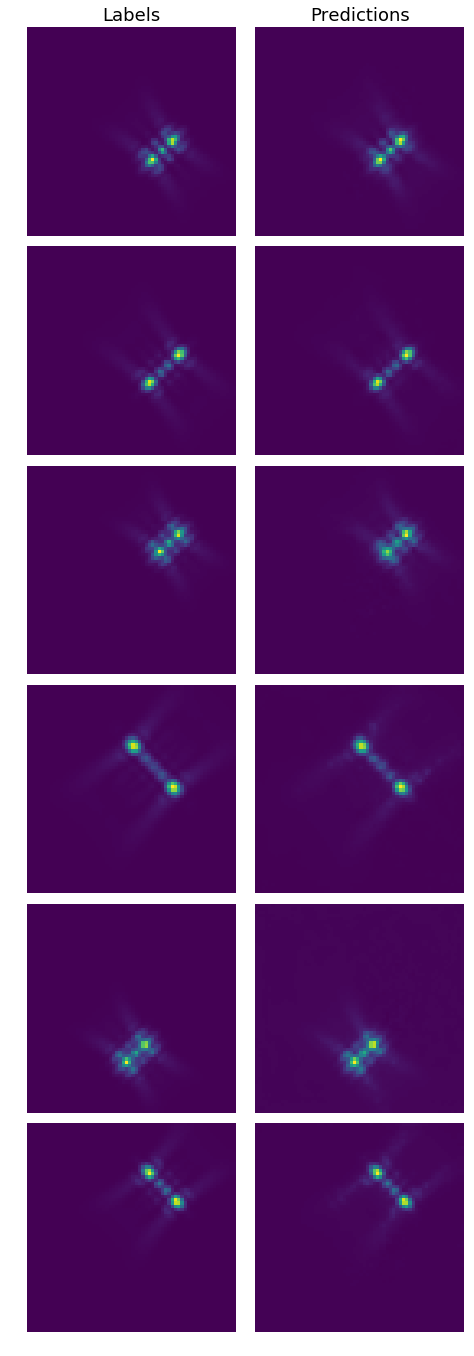

In [70]:
import numpy as np

def showPredictions(y_pred, y_labels):
        # Truncate dimensions
        imgSize, _, _ = np.shape(y_pred[0])
        y_preds = y_pred[0,:,:,:]
        y_tot = adjustNons(y_preds, y_labels)
        numSources = int(y_tot.shape[-1]/2)
        fig, axes = plt.subplots(numSources, 2, figsize=(8,4*numSources))
        
        for i in range(numSources):
            for j in range(2):
                axes[i,j].imshow(y_tot[:,:,i + j * numSources])
                axes[i,j].axis('off')
                
        axes = axes.flat
        axes[0].set_title('Labels', fontSize=18)
        axes[1].set_title('Predictions', fontSize=18)
        plt.subplots_adjust(hspace=0.05, wspace=0.05)
        plt.show()
        
def showPredictionsICA(y_pred, y_labels, y_ICA):
        # Truncate dimensions
        imgSize, _, _ = np.shape(y_pred[0])
        y_preds = y_pred[0,:,:,:]
        y_tot = adjustNonsICA(y_preds, y_labels, y_ICA)
        numSources = int(y_tot.shape[-1]/3)
        fig, axes = plt.subplots(numSources, 3, figsize=(8,4*numSources))
        
        for i in range(numSources):
            for j in range(3):
                axes[i,j].imshow(y_tot[:,:,i + j * numSources])
                axes[i,j].axis('off')
                
        axes = axes.flat
        axes[0].set_title('Labels', fontSize=18)
        axes[1].set_title('Predictions', fontSize=18)
        axes[2].set_title('ICA Estimation', fontSize=18)
        plt.subplots_adjust(hspace=0.05, wspace=0.05)
        plt.show()
        
        
sample_xe = np.expand_dims(sample_x, axis=0)
y_pred = model.predict(x = sample_xe)
# showPredictionsICA(y_pred, sample_y, y_ICA)
showPredictions(y_pred, sample_y)

# Learning Analysis

## Hyperparameter Optimization
In this project, we used a method of Bayesian Optimization in order to obatin a good set of hyperparameters. Searching the enitre space (grid search) may take a lot of time and random search makes it harder for us to find the optimal set as the hyperparameter space grows larger. The idea behind the Bayesian Optimization is to use another model of searching the hyperparameter space. One option is to use a Gaussian Process, in which we try to minimze the negative sign of the validation accuracy (or positive validation loss) by picking the sample that maximizes the expected improvement. At first, the optimizer gives us new suggestions in new regions of space and later on it tries to sample more in the regions of best estimated performance.

We wanted to find the following hyperparametrs:
1. Learning rate
2. Activation function
3. Number of convolutional (and deconvolutionl) bulks, where each bulk is composed of two convultional layers and a max pooling layer.
4. Kernel size

In [86]:
from skopt.space import Real, Categorical, Integer

dim_learning_rate = Real(low=1e-6, high=1e-2, prior='log-uniform', name='learning_rate')
dim_activation = Categorical(categories=['sigmoid', 'linear', 'relu'], name='activation')
dim_num_conv_Bulks = Integer(low=1, high=5, name='num_conv_Bulks')
dim_kernel_size = Categorical(categories=[3, 5], name='kernel_size')

### Search Results
The progress of the hyperparameter optimization can be plotted:
<img src="search_results/fig_converge.png" width="400">

One can observe each hyperparameter sample of the optimizer and its corresponding performance (MAE over the validation set at the end of each epoch).

In [59]:
with open(os.path.join('search_results', 'params_scores.h5'), 'rb') as paramsFile:
        search_results = pickle.load(paramsFile)

for p in search_results:
    print(p)

(0.14464257713407278, [0.0001, 2, 5, 'relu'])
(0.15573120145127178, [7.900491981905133e-05, 2, 5, 'relu'])
(0.15893739871680737, [0.0001, 2, 5, 'relu'])
(0.16133458372205495, [0.0001, 2, 5, 'relu'])
(0.1646715760231018, [0.0001, 2, 5, 'relu'])
(0.16494437381625177, [0.0001, 2, 5, 'relu'])
(0.1651221329346299, [0.0001, 2, 5, 'relu'])
(0.17342797182500364, [0.0001, 2, 5, 'relu'])
(0.17361316476017236, [0.0001, 2, 7, 'relu'])
(0.1760093618184328, [0.0001, 3, 5, 'relu'])
(0.1795260677114129, [0.0001, 2, 5, 'relu'])
(0.1838549254462123, [0.0001, 2, 5, 'relu'])
(0.18882118593901395, [0.0001, 1, 5, 'relu'])
(0.19131351672112942, [0.0001, 2, 7, 'relu'])
(0.1923415945842862, [0.0001, 2, 7, 'relu'])
(0.19952584467828274, [7.95767200646476e-06, 1, 11, 'relu'])
(0.20039208382368087, [0.0001, 2, 5, 'relu'])
(0.20250603500753642, [0.0001, 3, 5, 'linear'])
(0.20470354408025743, [3.66805126802478e-05, 2, 9, 'relu'])
(0.2089708622545004, [0.0001, 4, 9, 'linear'])
(0.21049080919474364, [2.64871371767922

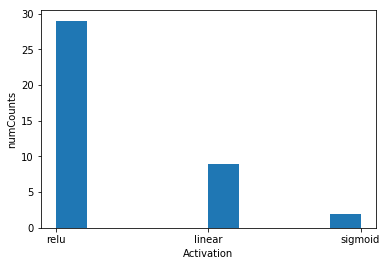

In [60]:
import SearchResult as sr

sr.plot_activation_hist(search_results)

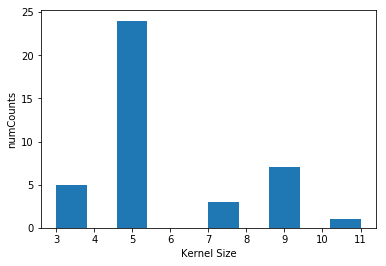

In [61]:
sr.plot_kernel_hist(search_results)

## Architecture

The model is implemented as an encoder-decoder network comprised of an input layer (64x64x64), 3 convolutional bulks (each conv bulk is composed of the conv2d layers and a max pooling layer), a flatten feature vector followed by 3 deconvolutional bulks (each deconv layer is composed of an upsampling layer and 2 conv2dTranspose layers and an output layer (64x64x32).
The number of filters in each convolutional layer was chosen to be $ 32^i $ for i=1,2,3 and the deconv bulks act as a mirror after the feature vector is obtained.

The number of convolutional bulks was set as a hyperparameter and the optimal one was found to be 3. The kernel size, which is another hyperparameter, was found to be 5 for the best performance. 

The model's architecture:

<img src="search_results/arch.png" width="400">

## Training and Validation
After the hyperparameter optimization process is done and we obtained the best set of parameters evaluated over the validation set, we can now use them to build our model and train it. 

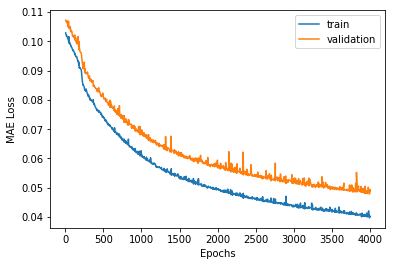

In [22]:
train_loss = np.genfromtxt(os.path.join('search_results', 'run_lr-3e-05_bulks-3_kernel-5_act-relu-tag-loss.csv'), 
                                delimiter=',')
val_loss   = np.genfromtxt(os.path.join('search_results', 'run_lr-3e-05_bulks-3_kernel-5_act-relu-tag-val_loss.csv'), 
                                delimiter=',')

fig, ax = plt.subplots()
ax.plot(train_loss[:,1], train_loss[:,2], label='train')
ax.plot(val_loss[:,1], val_loss[:,2], label='validation')
plt.xlabel('Epochs')
plt.ylabel('MAE Loss')
plt.legend()
plt.show()

From the MAE loss plot above, one can observe that a plateau is not yet reached for the validation loss, implying that the trained model is not overfitting. However, it seems like it is getting close to the overfitting state. In this case, training our model on new samples (expanding our training set) would probably be more beneficial than running more training epochs over the current dataset. 